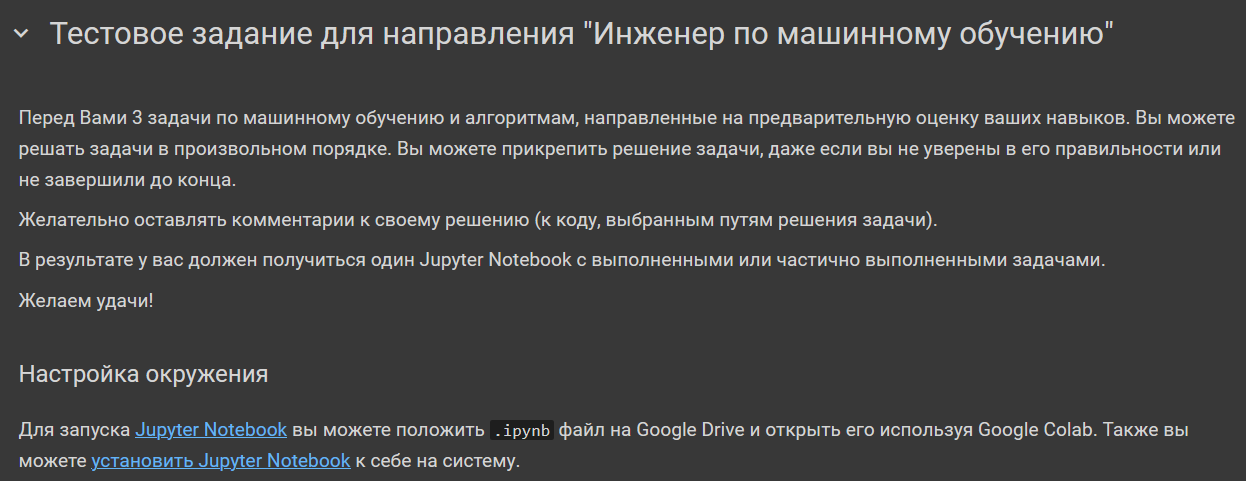

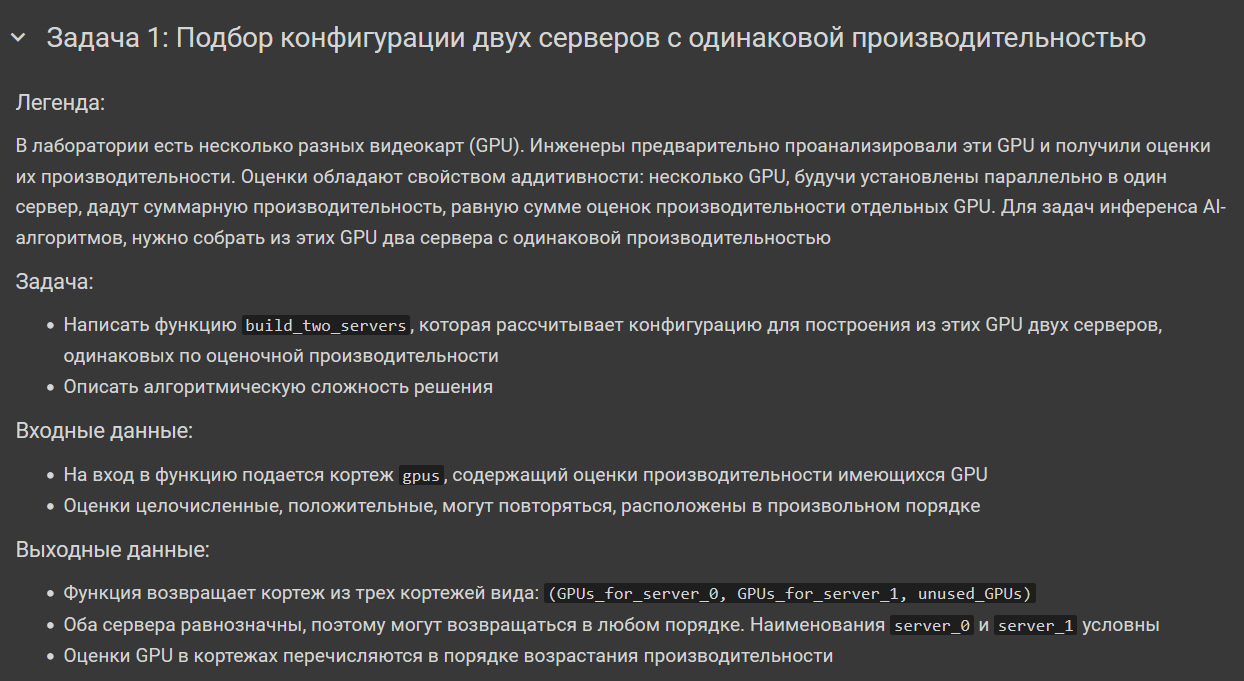

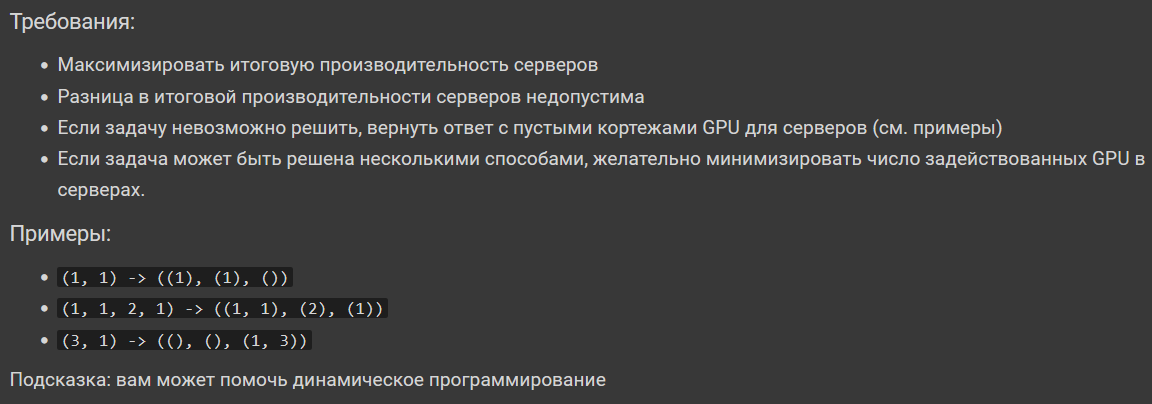

In [ ]:
import numpy as np
from itertools import combinations
from typing import Tuple


def get_combination(even_sum_combinations_sorted: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Получение комбинации, в которой можно сложить любые числа так,
    чтобы получилась ровно половина от суммы всех чисел, которые есть в этой комбинации.

    Аргументы:
        even_sum_combinations_sorted (np.ndarray): Отсортированный по убыванию
        np.ndarray комбинаций с четной суммой.

    Возвращает:
        Tuple[np.ndarray, np.ndarray]: Кортеж, содержащий
        gpu для каждого сервера и неиспользованные gpu.
    """

    for item in even_sum_combinations_sorted:
        numbers = item[0]  # комбинация чисел
        total_sum = item[1]  # сумма всех чисел в этой комбинации
        unused_numbers = item[2]  # неиспользованные числа

        # Половина суммы всех чисел в исходном массиве
        target_sum = total_sum / 2
        target_combinations = []

        # Нахождение всех комбинаций чисел и их суммы
        for r in range(1, len(numbers) + 1):
            for combo in combinations(numbers, r):
                # Вычисление суммы всех чисел в комбинации
                total_sum = sum(combo)
                # Если была полученная сумма, равная половине от суммы всех
                # чисел в последовательности, то останавливаем цикл.
                if total_sum == target_sum:
                    target_combinations.append(combo)
                    break

        return target_combinations, unused_numbers



def build_two_servers(gpus: Tuple[int]) -> Tuple[Tuple[int], Tuple[int], Tuple[int]]:
    """
    Разделение GPU на два сервера равные по производительности.

    Аргументы:
        gpus (Tuple[int]): Кортеж, содержащий целые числа отображающие производительность GPU.

    Возвращает:
        Tuple[Tuple[int], Tuple[int], Tuple[int]]: Кортеж, содержащий кортежи
        распределенных GPU для двух серверов и неиспользованные GPU.
    """

    if not gpus:
        result = ((), (), ())

    if len(gpus) <= 4:

        unused_gpu = sorted(gpus, reverse=True)

        server_0 = []
        server_1 = []
        server_0_load = 0
        server_1_load = 0


        if gpus:
            result = ((), (), tuple(sorted(unused_gpu)))

        unused_gpu_copy = unused_gpu.copy()

        for gpu in unused_gpu_copy:
            if server_0_load <= server_1_load:
                server_0.append(gpu)
                server_0_load += gpu
                unused_gpu.remove(gpu)
            else:
                server_1.append(gpu)
                server_1_load += gpu
                unused_gpu.remove(gpu)

            if server_0_load == server_1_load:
                result = (tuple(sorted(server_0)), tuple(sorted(server_1)), tuple(sorted(unused_gpu)))
    else:

        numbers = np.array(gpus)
        even_sum_combinations = np.empty((0, 3), dtype=object)

        # Генерация всех возможных комбинаций
        for r in range(1, len(numbers) + 1):
            for combo in combinations(numbers, r):
                # Вычисление суммы всех чисел в комбинации
                total_sum = np.sum(combo)
                # Получение только четных комбинации т.к. нечетную производительность
                # gpu точно не получится разделить на два сервера.
                if total_sum % 2 == 0:
                    unused_numbers = np.setdiff1d(numbers, combo)
                    even_sum_combinations = np.append(even_sum_combinations, np.array([(combo, total_sum, unused_numbers)], dtype=object), axis=0)

        # Сортировка результатов по сумме в обратном порядке
        even_sum_combinations_sorted = even_sum_combinations[np.argsort(even_sum_combinations[:, 1])[::-1]]
        servers, unused_gpu = get_combination(even_sum_combinations_sorted)
        result = (tuple(sorted(servers[0])), tuple(sorted(servers[1])), tuple(sorted(unused_gpu)))


    return result


various_gpus = (
    (1, 1),       # GPUs: (1, 1), server_0: (1), server_1: (1), unused: ()
    (1, 1, 2, 1), # GPUs: (1, 1, 2, 1), server_0: (1, 1), server_1: (2), unused: (1)
    (3, 1),       # GPUs: (3, 1), server_0: (), server_1: (), unused: (1, 3)
    (),           # GPUs: (), server_0: (), server_1: (), unused: ()
    (2, 2, 5, 6, 7, 3), # ...
    (78, 35, 34, 1, 2, 3, 1, 2, 1, 1)
)

for gpus in various_gpus:
    result = build_two_servers(gpus)
    print(f"GPUs: {gpus}, server_0: {result[0]}, server_0: {result[1]}, unused: {result[2]}")
    assert sum(result[0]) == sum(result[1])

GPUs: (1, 1), server_0: (1,), server_0: (1,), unused: ()
GPUs: (1, 1, 2, 1), server_0: (2,), server_0: (1, 1), unused: (1,)
GPUs: (3, 1), server_0: (), server_0: (), unused: (1, 3)
GPUs: (), server_0: (), server_0: (), unused: ()
GPUs: (2, 2, 5, 6, 7, 3), server_0: (5, 6), server_0: (2, 2, 7), unused: (3,)
GPUs: (78, 35, 34, 1, 2, 3, 1, 2, 1, 1), server_0: (1, 78), server_0: (1, 1, 1, 2, 2, 3, 34, 35), unused: ()


## Задача 2: Анализ диалогов из фильма

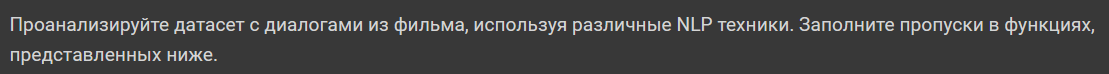

### Установка необходимых библиотек и загрузка датасета

In [ ]:
# Download the necessary libraries
! pip install pandas seaborn matplotlib nltk wordcloud transformers wget
! pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
import nltk
nltk.download('stopwords')

Looking in indexes: https://download.pytorch.org/whl/cpu
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.4/190.4 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.8/186.8 MB 2.5 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.2.1+cu121
    Uninstalling torch-2.2.1+cu121:
      Successfully uninstalled torch-2.2.1+cu121


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Download and read dataset
import pandas as pd
import wget
filename = wget.download("https://drive.usercontent.google.com/download?id=1zO99vPGpw7yi6m45pd-Wq12z9-qXPWnv&confirm=xxx")

dataset = pd.read_csv(filename, sep='\s+', names=["index","character","dialogue"], header=0)
dataset.head()

,index,character,dialogue
0,1,LUKE,"Echo Three to Echo Seven. Han, old buddy, do y..."
1,2,HAN,"Loud and clear, kid. What's up?"
2,3,LUKE,"Well, I finished my circle. I don't pick up an..."
3,4,HAN,There isn't enough life on this ice cube to fi...
4,5,LUKE,Right. I'll see you shortly. There's a meteori...


### Подзадача 2.1. Постройте гистограмму top-10 персонажей по количеству слов в диалогах
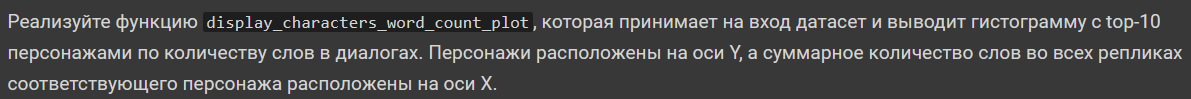

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def display_characters_word_count_plot(dataset: DataFrame) -> None:
    """
    Отображение гистрограммы, показывающей топ-10 персонажей по количеству слов в репликах.

    Аргументы:
        dataset (DataFrame): Входной набор данных, содержащий реплики.
    """
    top_10_characters = dataset['character'].value_counts().head(10)

    fig_font = 12
    plt.figure(figsize=(10, 6))
    plt.barh(top_10_characters.index, top_10_characters.values, color='deepskyblue')
    plt.xlabel('Суммарное количество слов', fontsize=fig_font)
    plt.ylabel('Персонаж', fontsize=fig_font)
    plt.title('Топ-10 персонажей по количеству слов в диалогах', fontweight='bold', fontsize=14, color='black')
    plt.gca().invert_yaxis()
    plt.show()

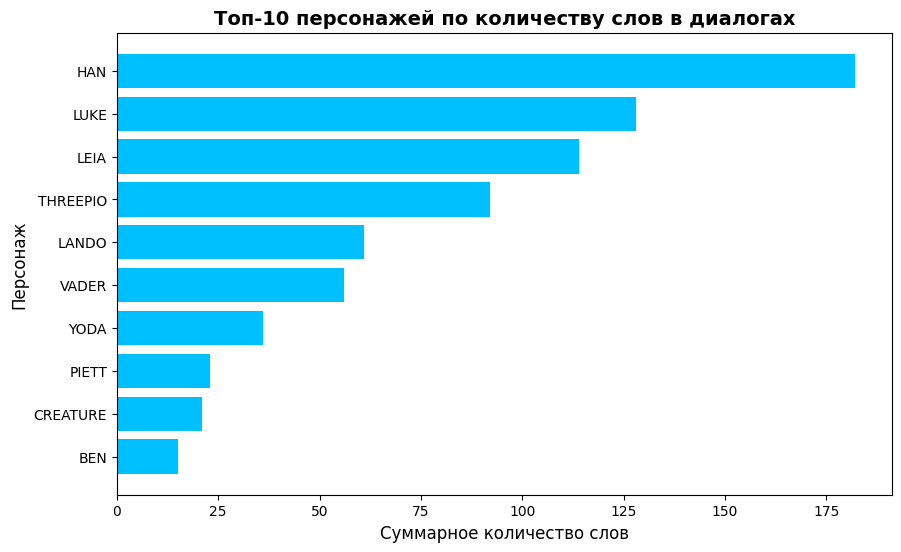

In [ ]:
# Call funtion to display plot
display_characters_word_count_plot(dataset)

### Подзадача 2.2. Определите наиболее часто встречаемые слова в фразах Люка Скайуокера
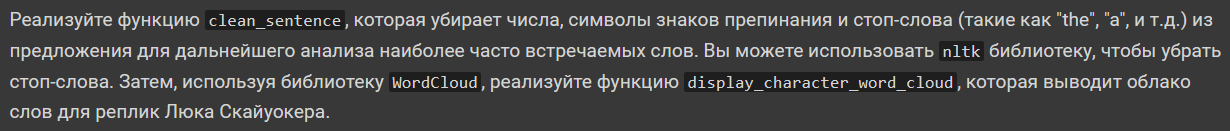

In [ ]:
from nltk.corpus import stopwords
import string
from collections import Counter
from wordcloud import WordCloud

In [ ]:
def clean_sentence(sentence: str) -> str:
    """
    Очистка входного предложения путем удаления чисел, знаков пунктуации и стоп-слов.

    Аргументы:
        sentence (str): Входное предложение для очистки.

    Результат:
        str: Очищенное предложение.
    """
    # Удаление чисел и символов пунктуации
    cleaned_sentence = ''.join([char for char in sentence if char not in string.punctuation and not char.isdigit()])
    # Разбиение предложения на слова
    words = cleaned_sentence.split()
    # Удаление стоп-слов
    stop_words = set(stopwords.words('english'))
    cleaned_words = [word for word in words if word.lower() not in stop_words]
    # Объединение слов обратно в предложение
    cleaned_sentence = ' '.join(cleaned_words)

    return cleaned_sentence


In [ ]:
# Create clean_dialogue column using clean_sentence function. Show top-10 most common words.

dataset['clean_dialogue']=dataset['dialogue'].map(lambda sentence:clean_sentence(sentence))
common_words = Counter(" ".join(dataset["clean_dialogue"]).split()).most_common(10)
common_words

[('Im', 61),
 ('dont', 54),
 ('Oh', 40),
 ('know', 36),
 ('Yes', 36),
 ('going', 35),
 ('right', 32),
 ('Well', 30),
 ('get', 29),
 ('Artoo', 27)]

In [ ]:
def display_character_word_cloud(character_data: DataFrame) -> None:
    """
    Отображение облака слов для реплик указанного персонажа.

    Аргументы:
        character_data (DataFrame): DataFrame, содержащий реплики для персонажа.
    """
    # Объединение всех реплик в одну строку
    text = ' '.join(character_data['clean_dialogue'])

    # Создание облака слов
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Word Cloud for Luke Skywalker')
    plt.axis('off')
    plt.show()

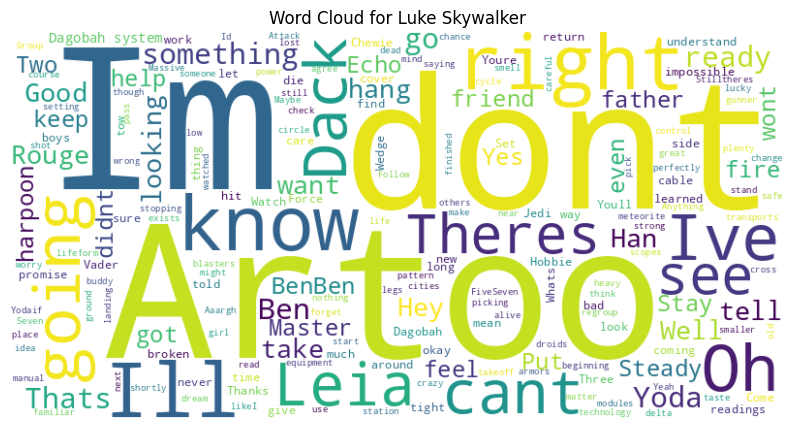

In [ ]:
# Call funtion to display Luke Skywalker's WordCloud
display_character_word_cloud(dataset[dataset['character']=='LUKE'])

### Подзадача 2.3. Анализ эмоций в диалогах
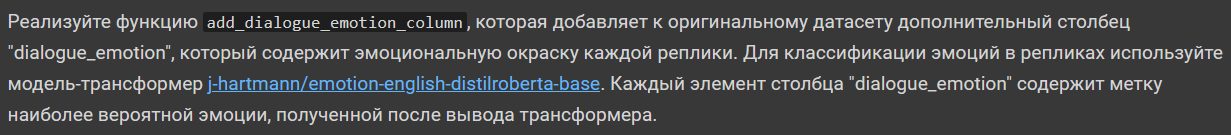

In [ ]:
from transformers import pipeline
from pandas.core.frame import DataFrame

In [ ]:
def classify_emotion(dialogue: str) -> str:
    """
    Классификация эмоции в реплике.

    Аргументы:
        dialogue (str): Реплика.

    Возвращает:
        str: Классифицированная эмоциональная метка.
    """
    result = classifier(dialogue)

    return result[0]['label']


def add_dialogue_emotion_column(dataset: DataFrame) -> DataFrame:
    """
    Добавление столбца 'dialogue_emotion' в набор данных, содержащего
    эмоциональную окраску каждой реплики.

    Аргументы:
        dataset (DataFrame): Входной набор данных, содержащий реплики.

    Возвращает:
        DataFrame: Набор данных с добавленным столбцом 'dialogue_emotion'.
    """

    # Загрузка модели для классификации эмоций
    classifier = pipeline("sentiment-analysis", model="j-hartmann/emotion-english-distilroberta-base")

    # Добавление столбеца 'dialogue_emotion', содержащего эмоциональную окраску каждой реплики
    dataset['dialogue_emotion'] = dataset['dialogue'].apply(classify_emotion)

    return dataset

In [ ]:
# Show value_counts of dialogue_emotion column
updated_dataset = add_dialogue_emotion_column(dataset)
updated_dataset['dialogue_emotion'].value_counts()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

dialogue_emotion
neutral     434
surprise    121
anger       107
fear         56
disgust      45
sadness      41
joy          35
Name: count, dtype: int64

### Подзадача 2.4. Распределение эмоций Люка Сайуокера
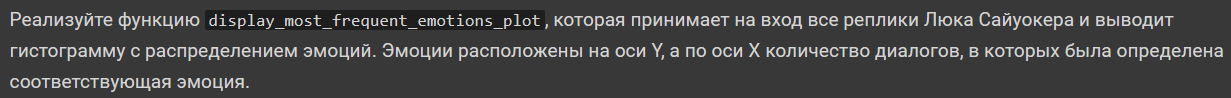


In [ ]:
def display_most_frequent_emotions_plot(character_data: DataFrame) -> None:
    """
    Отображение гистограммы, показывающей распределение эмоций в репликах Люка Скайуокера.

    Аргументы:
        character_data (DataFrame): DataFrame, содержащий реплики для Люка Скайуокера.
    """

    # Подсчет количества каждой эмоции
    emotions_count = character_data['dialogue_emotion'].value_counts()

    emotions_count = emotions_count.sort_values(ascending=True)
    fig_font = 12


    plt.figure(figsize=(10, 6))
    emotions_count.plot(kind='barh', color='deepskyblue')
    plt.xlabel('Количество диалогов', fontsize=fig_font)
    plt.ylabel('Эмоция', fontsize=fig_font)
    plt.title('Распределение эмоций в репликах Люка Скайуокера', fontweight='bold', fontsize=14, color='black')
    plt.show()

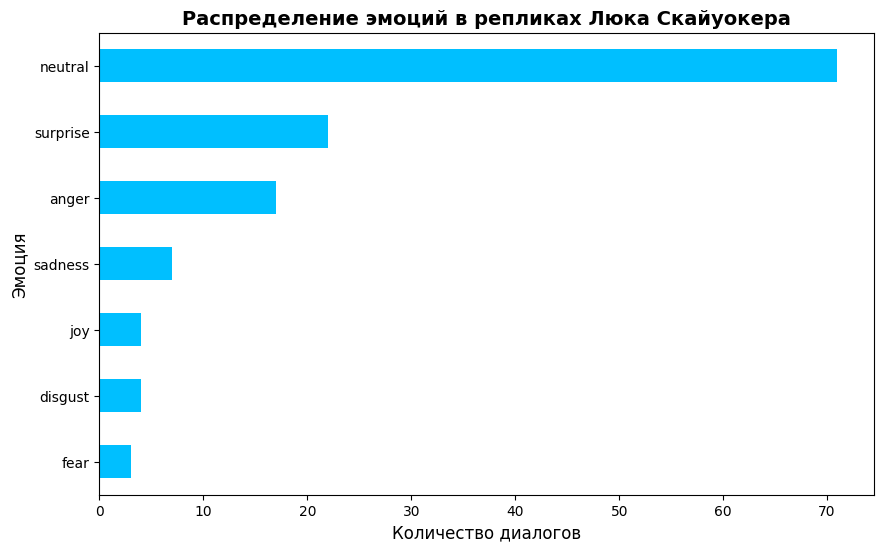

In [ ]:
# Call funtion to display plot
display_most_frequent_emotions_plot(updated_dataset[updated_dataset['character']=='LUKE'])

## Задача 3. Прогнозирование исчерпания места на HDD

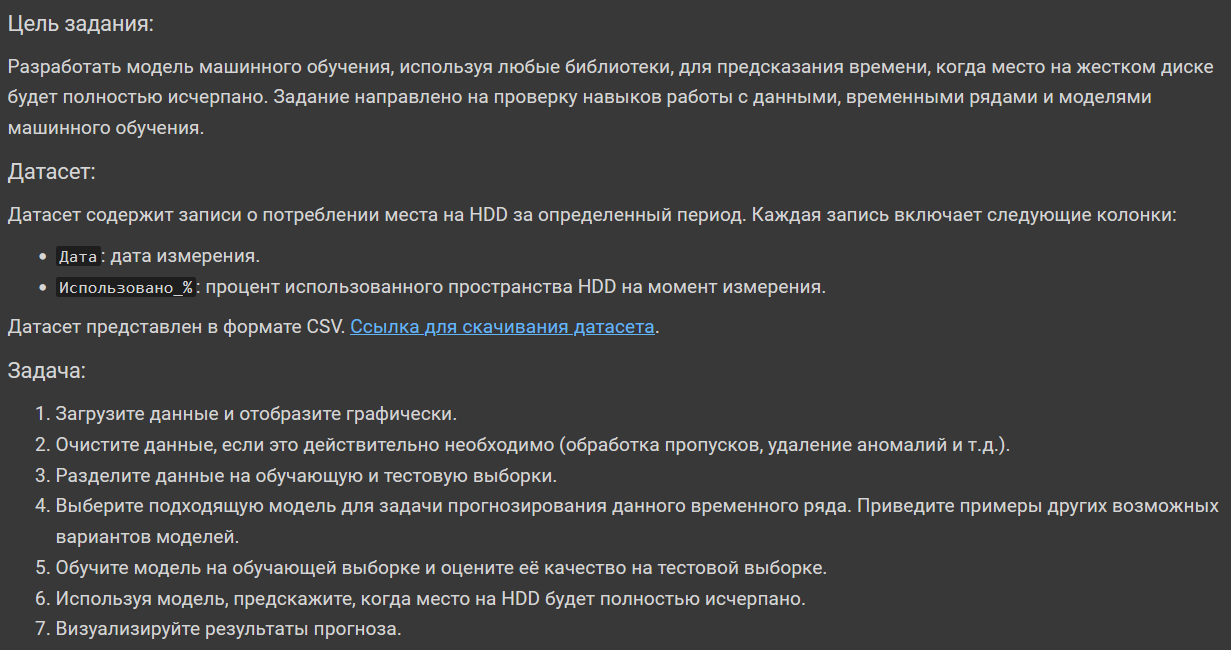

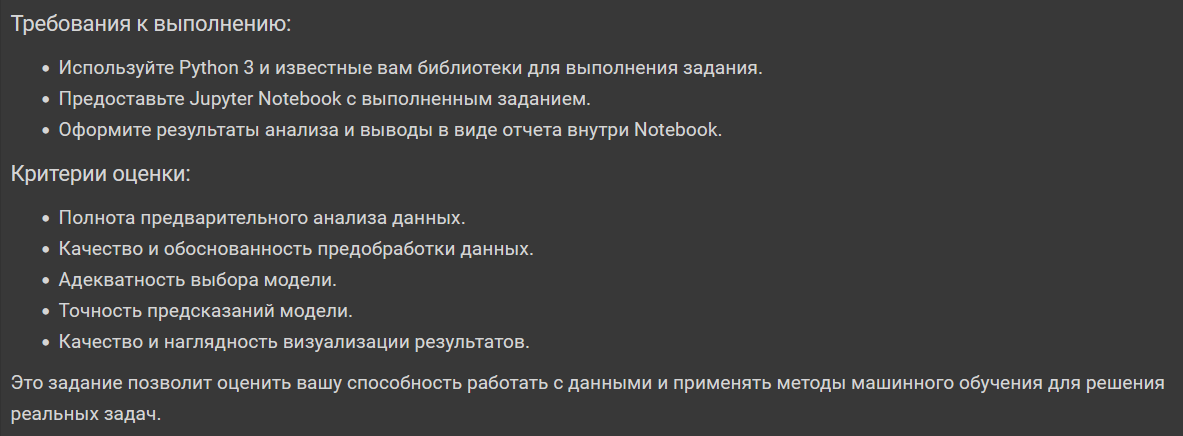

#### 1. Загрузите данные и отобразите графически.

In [ ]:
! pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=612618e057bed301b0d6861f6f86827198036203ee9c27c9470fba4e34eb75e6
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
import pandas as pd
from math import floor, ceil, sqrt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import wget

In [ ]:
data = pd.read_csv(wget.download("https://drive.usercontent.google.com/download?id=1wZz4N0nw1yH2LGnFy3dPHgDqNanGUkM9&confirm=xxx"))
data

,Дата,Использовано_%
0,0,28.820262
1,1,22.000786
2,2,24.893690
3,3,31.204466
4,4,29.337790
...,...,...
95,95,78.634907
96,96,76.379031
97,97,86.480373
98,98,79.410071


In [ ]:
# Отображение информации о датафрейме
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Дата            100 non-null    int64  
 1   Использовано_%  100 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 1.7 KB


In [ ]:
# Отображение статистики о числовых данных в датафрейме
data.describe()

,Дата,Использовано_%
count,100.000000,100.000000
mean,49.500000,35.299040
std,29.011492,20.724585
min,0.000000,7.235051
25%,24.750000,20.145333
50%,49.500000,27.408595
75%,74.250000,48.643181
max,99.000000,86.480373


В предоставленных данных нет отсутствующих значений(Nan).

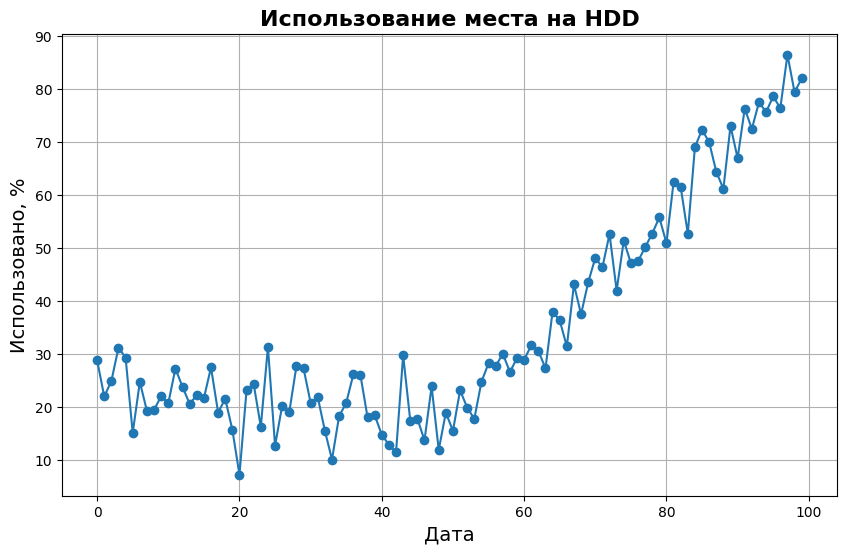

In [ ]:
# Визуализация данных
plt.figure(figsize=(10, 6))
mpl.rcParams['figure.dpi'] = 200
fig_font = 14

plt.plot(data['Дата'], data['Использовано_%'], marker='o', linestyle='-')
plt.title('Использование места на HDD', fontweight='bold', fontsize=16, color='black')
plt.xlabel('Дата', fontsize=fig_font)
plt.ylabel('Использовано, %', fontsize=fig_font)
plt.grid(True)
plt.show()

На графике не видно явных выбросов или аномальных значений.

#### 3. Разделите данные на обучающую и тестовую выборки.

In [ ]:
# Применение MinMaxScaler для нормализации данных
scaler = MinMaxScaler(feature_range=(0, 1))
# Задаем окно, на основании которого будет строиться прогноз
prediction_days = 40


shape = data.shape[0]
df_new = data[['Использовано_%']]
df_new.head()
# Разделение данных на обучающую и тестовую выборки
dataset = df_new.values
train = df_new[:ceil(shape * 0.75)]
test = df_new[ceil(shape * 0.75):]

In [ ]:
# Нормализация данных обучающей выборки
scaled_data = scaler.fit_transform(dataset)
x_train, y_train = [], []
for i in range(60, len(train)):
    x_train.append(scaled_data[i-prediction_days:i, 0])
    y_train.append(scaled_data[i, 0])

# Изменение формы обучающей выборки, для соответствия GRU
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
# Преобразование и нормализация данных в тестовой выборке
inputs = df_new[len(df_new) - len(test) - prediction_days:].values
inputs = inputs.reshape(-1, 1)
inputs = scaler.transform(inputs)

X_test = []
for i in range(prediction_days, inputs.shape[0]):
    X_test.append(inputs[i-prediction_days:i, 0])

# Изменение формы тестовой выборки, для соответствия GRU
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

#### 4. Выберите подходящую модель для задачи прогнозирования данного временного ряда. Приведите примеры других возможных вариантов моделей.

Наиболее подходящими моделями для решения поставленной задачи, по моему мнению, являются рекуррентные нейронные сети, такие как LSTM и GRU.

In [ ]:
# Создание модели GRU c помощью keras
model = Sequential()
model.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(GRU(units=50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Вывод количества параметров и формы для каждого слоя
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 40, 50)            7950      
                                                                 
 gru_1 (GRU)                 (None, 50)                15300     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 23301 (91.02 KB)
Trainable params: 23301 (91.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


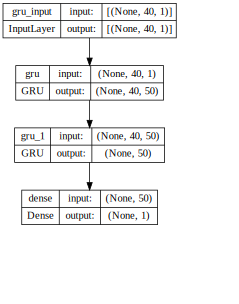

In [ ]:
# Отображение графического представления нейронной сети
dot_img = model_to_dot(model, show_shapes=True)
SVG(dot_img.create(prog='dot', format='svg'))

#### 5. Обучите модель на обучающей выборке и оцените её качество на тестовой выборке.

In [ ]:
# Обучение модели
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2, validation_split=0.1)

13/13 - 10s - loss: 0.0316 - val_loss: 0.0170 - 10s/epoch - 789ms/step


In [ ]:
# Получение предсказаний
closing_price = model.predict(X_test)
# Получение значений в исходном формате из предсказаний
closing_price = scaler.inverse_transform(closing_price)
# Вычисление RMSE (среднеквадратической ошибки)
rms = np.sqrt(np.mean(np.power((test - closing_price), 2)))
print('RMSE на тестовой выборке:', rms)

1/1 [==============================] - 2s 2s/step
RMSE на тестовой выборке: 6.322170095229958


<ipython-input-14-ec6924f918eb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:,'Predictions'] = closing_price


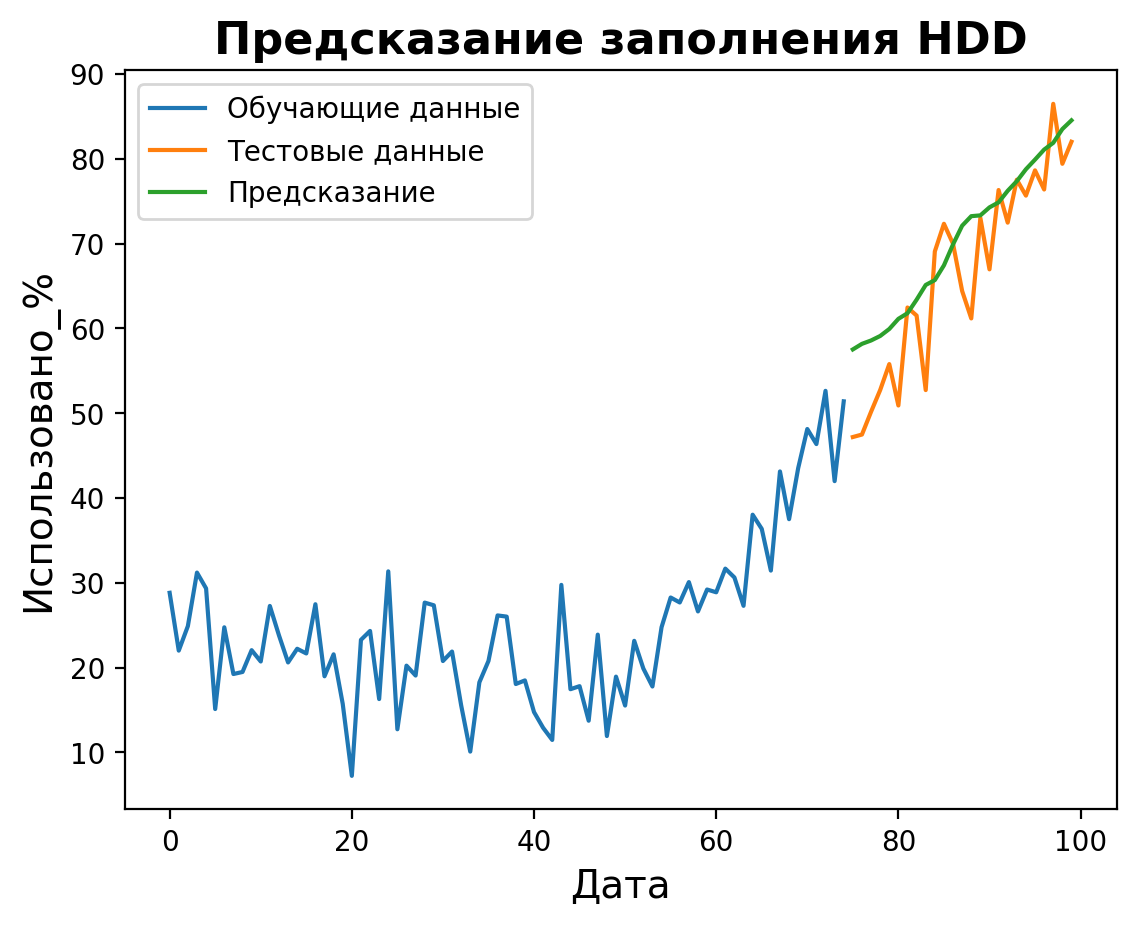

In [ ]:
test.loc[:,'Predictions'] = closing_price
fig_font = 14

plt.plot(train['Использовано_%'])
plt.plot(test[['Использовано_%', 'Predictions']])

plt.xlabel('Дата', fontsize=fig_font)
plt.ylabel('Использовано_%', fontsize=fig_font)
plt.title('Предсказание заполнения HDD', fontweight='bold', fontsize=16, color='black')
plt.legend(['Обучающие данные', 'Тестовые данные', 'Предсказание'])

#### 6. Используя модель, предскажите, когда место на HDD будет полностью исчерпано.

In [ ]:
prediction_days = 40
df = pd.read_csv(wget.download("https://drive.usercontent.google.com/download?id=1wZz4N0nw1yH2LGnFy3dPHgDqNanGUkM9&confirm=xxx"))
scaler = MinMaxScaler(feature_range=(0, 1))

# Цикл для предсказания следующих 20-и значений по одному за итерацию
for ind in range(len(df)+1,len(df)+21):
    shape = df.shape[0]
    df_new = df[['Использовано_%']]
    df_new.head()
    dataset = df_new.values
    train = df_new[:ceil(shape * 0.75)]
    test = df_new[ceil(shape * 0.75):]

    scaled_data = scaler.fit_transform(dataset)
    x_train, y_train = [], []
    for i in range(60, len(train)):
        x_train.append(scaled_data[i-prediction_days:i, 0])
        y_train.append(scaled_data[i, 0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    inputs = df_new[len(df_new) - len(test) - prediction_days:].values
    inputs = inputs.reshape(-1, 1)
    inputs = scaler.transform(inputs)

    X_test = []

    for i in range(prediction_days, inputs.shape[0]):
        X_test.append(inputs[i-prediction_days:i, 0])

    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    closing_price = model.predict(X_test)
    closing_price = scaler.inverse_transform(closing_price)

    rms = np.sqrt(np.mean(np.power((test - closing_price), 2)))
    print('RMSE на тестовой выборке:', rms)

    # Предсказание следующего значения
    real_data = [inputs[len(inputs) + 1 - prediction_days:len(inputs) + 1, 0]]
    real_data = np.array(real_data)
    real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

    prediction = model.predict(real_data)
    prediction = scaler.inverse_transform(prediction)
    single_prediction = float(prediction[0][0])
    print(f"Предсказание: {single_prediction}")

    # Добавление предсказанного значения в исходны датафрейм
    df.loc[len(df.index)] = [ind, single_prediction]

1/1 [==============================] - 0s 118ms/step
RMSE на тестовой выборке: 6.322170095229958
1/1 [==============================] - 2s 2s/step
Предсказание: 85.39998626708984
1/1 [==============================] - 0s 215ms/step
RMSE на тестовой выборке: 5.974909858028697
1/1 [==============================] - 0s 155ms/step
Предсказание: 86.46064758300781
1/1 [==============================] - 0s 176ms/step
RMSE на тестовой выборке: 5.5789546845288704
1/1 [==============================] - 0s 97ms/step
Предсказание: 87.59428405761719
1/1 [==============================] - 0s 100ms/step
RMSE на тестовой выборке: 5.453118666844365
1/1 [==============================] - 0s 204ms/step
Предсказание: 89.0066146850586
1/1 [==============================] - 0s 234ms/step
RMSE на тестовой выборке: 5.526002987829338
1/1 [==============================] - 0s 157ms/step
Предсказание: 90.49281311035156
1/1 [==============================] - 0s 124ms/step
RMSE на тестовой выборке: 5.5479209996584

In [ ]:
df[df['Использовано_%'] > 99].head()

,Дата,Использовано_%
110,111.0,99.955269
111,112.0,101.631073
112,113.0,103.337212
113,114.0,105.074188
114,115.0,106.842529


Место на HDD будет исчерпано через 12 дат (на 112-ой дате).



#### 7. Визуализируйте результаты прогноза.

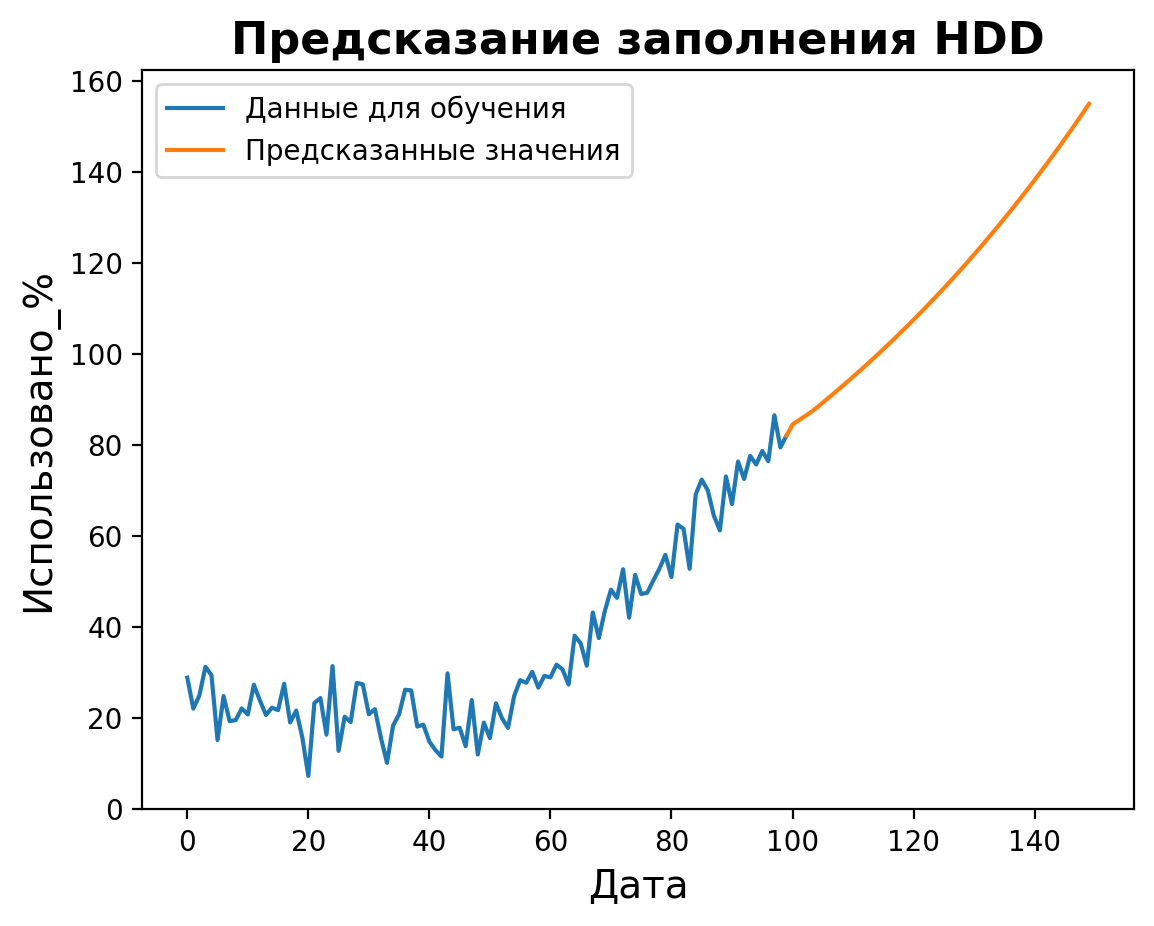

In [ ]:
mpl.rcParams['figure.dpi'] = 200
fig_font = 14

plt.plot(train['Использовано_%'].head(100))
plt.plot(df['Использовано_%'].tail(51))
plt.xlabel('Дата', fontsize=fig_font)
plt.ylabel('Использовано_%', fontsize=fig_font)
plt.title('Предсказание заполнения HDD', fontweight='bold', fontsize=16, color='black')
plt.legend(['Данные для обучения', 'Предсказанные значения'])